In [1]:
#Step 1: Import Libraries and Load Data


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Preview data
print(customers.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [2]:
#Step 2: Feature Engineering


# Aggregate transaction data for each customer
transactions_agg = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count',  # Number of transactions
}).reset_index()

# Rename columns
transactions_agg.rename(columns={
    'TotalValue': 'TotalSpend',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
}, inplace=True)

# Merge with customer profile data
customer_data = pd.merge(customers, transactions_agg, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)  # Fill missing transaction data with 0

# Select features for clustering
features = ['TotalSpend', 'TotalQuantity', 'TransactionCount']
print(customer_data[features].describe())

         TotalSpend  TotalQuantity  TransactionCount
count    200.000000     200.000000        200.000000
mean    3449.977800      12.685000          5.000000
std     1844.435391       6.201457          2.221412
min        0.000000       0.000000          0.000000
25%     2137.540000       8.000000          3.000000
50%     3137.420000      12.000000          5.000000
75%     4764.412500      17.000000          6.000000
max    10673.870000      32.000000         11.000000


In [3]:
#Step 3: Feature Scaling
#Normalize features for fair clustering.


# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features)

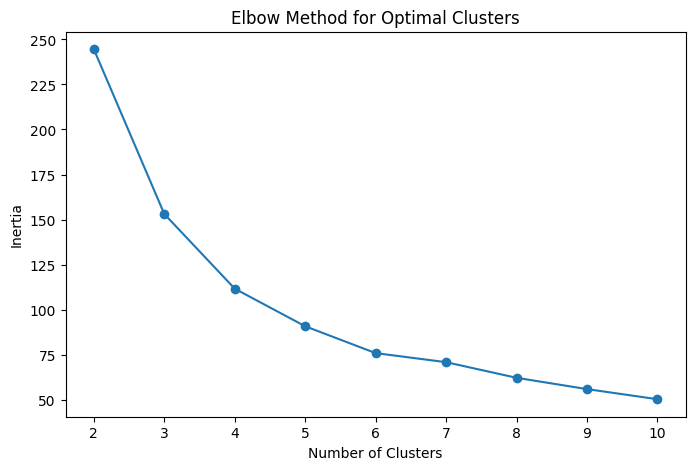

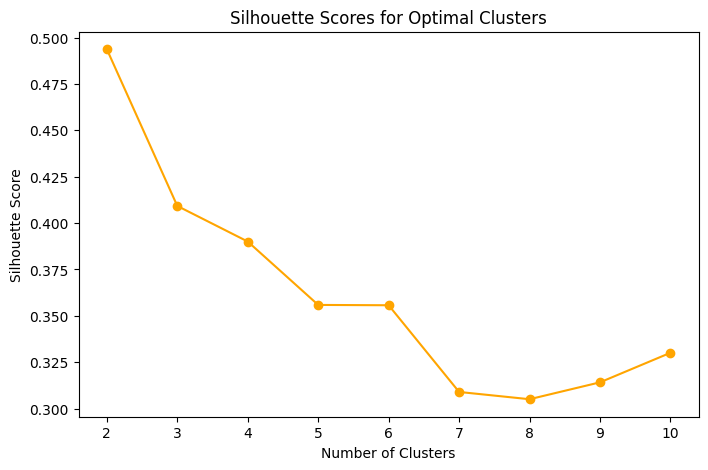

In [4]:
#Step 4: Determine Optimal Clusters
#Use the Elbow Method and Silhouette Scores to determine the optimal number of clusters.


# Elbow Method for optimal clusters
inertia = []
silhouette_scores = []

for k in range(2, 11):  # Clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [5]:
#Step 5: Apply Clustering Algorithm
#Choose the optimal number of clusters (e.g., k=4 based on results).


# Apply K-Means with optimal clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_df)

# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_df, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.8052437830269734


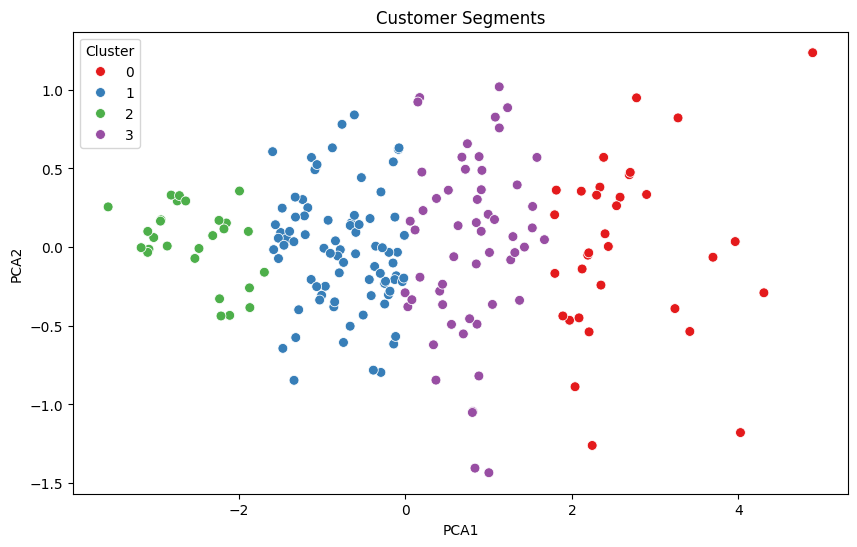

In [6]:
#Step 6: Visualize Clusters
#Use PCA to reduce dimensions and visualize clusters in 2D.


# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_df)
customer_data['PCA1'] = pca_features[:, 0]
customer_data['PCA2'] = pca_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data,
    palette='Set1', s=50
)
plt.title('Customer Segments')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()